# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

base_path = "/Users/yijuilee/project_robyn/robynpy_interfaces/Robyn/R/data"
python_path = "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src"
sys.path.append(base_path)
sys.path.append(python_path)

In [2]:
import os
import pandas as pd
import pyreadr
from typing import Dict
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.feature_engineering import FeatureEngineering

/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
def load_data() -> Dict[str, pd.DataFrame]:
    if not base_path:
        raise EnvironmentError("Please set the ROBYN_BASE_PATH environment variable")

    simulated_weekly_path = os.path.join(base_path, "dt_simulated_weekly.RData")
    prophet_holidays_path = os.path.join(base_path, "dt_prophet_holidays.RData")

    result = pyreadr.read_r(simulated_weekly_path)
    dt_simulated_weekly = result["dt_simulated_weekly"]
    result_holidays = pyreadr.read_r(prophet_holidays_path)
    dt_prophet_holidays = result_holidays["dt_prophet_holidays"]

    return {"dt_simulated_weekly": dt_simulated_weekly, "dt_prophet_holidays": dt_prophet_holidays}


data = load_data()

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(data: Dict[str, pd.DataFrame]) -> MMMData:
    dt_simulated_weekly = data["dt_simulated_weekly"]

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        factor_vars=["events"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(data)

## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=0.0,
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=data["dt_prophet_holidays"],
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)

In [7]:
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)
featurized_mmm_data = feature_engineering.perform_feature_engineering()

19:10:23 - cmdstanpy - INFO - Chain [1] start processing
2024-10-21 19:10:23 - cmdstanpy - INFO - Chain [1] start processing
19:10:23 - cmdstanpy - INFO - Chain [1] done processing
2024-10-21 19:10:23 - cmdstanpy - INFO - Chain [1] done processing
2024-10-21 19:10:23 - robyn.modeling.feature_engineering - INFO - Prophet decomposition complete.
2024-10-21 19:10:23 - robyn.modeling.feature_engineering - INFO - Processing tv_S
2024-10-21 19:10:24 - robyn.modeling.feature_engineering - INFO - Processing ooh_S
2024-10-21 19:10:25 - robyn.modeling.feature_engineering - INFO - Processing print_S
2024-10-21 19:10:26 - robyn.modeling.feature_engineering - INFO - Processing facebook_S
2024-10-21 19:10:26 - robyn.modeling.feature_engineering - INFO - Processing search_S
2024-10-21 19:10:26 - robyn.modeling.feature_engineering - INFO - Feature engineering complete.


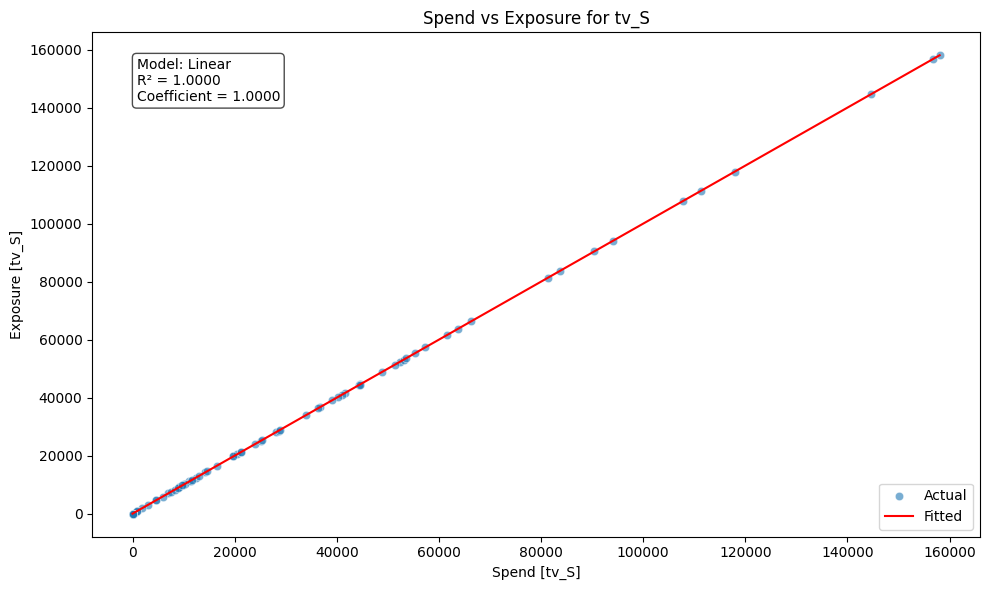

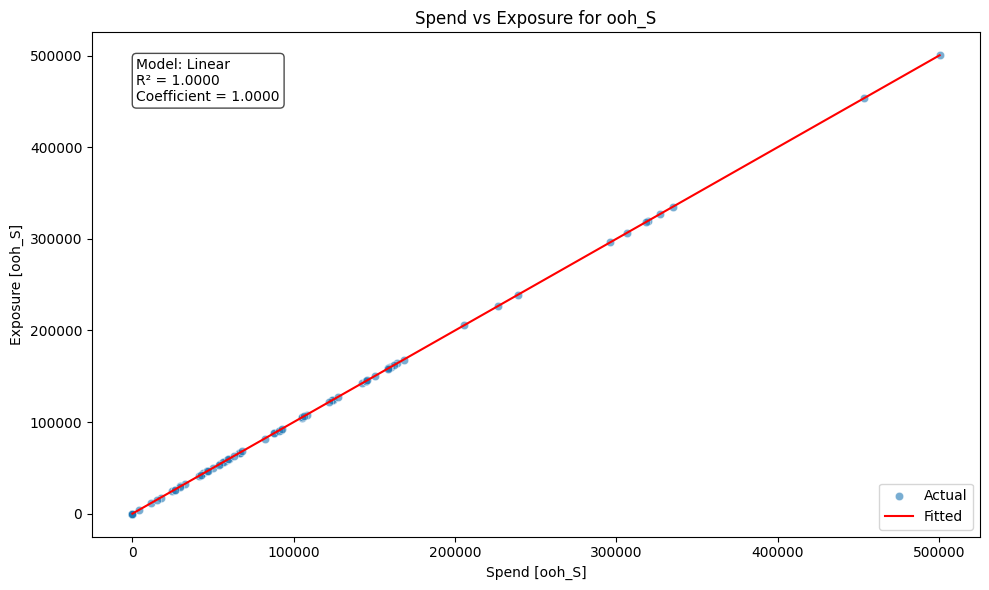

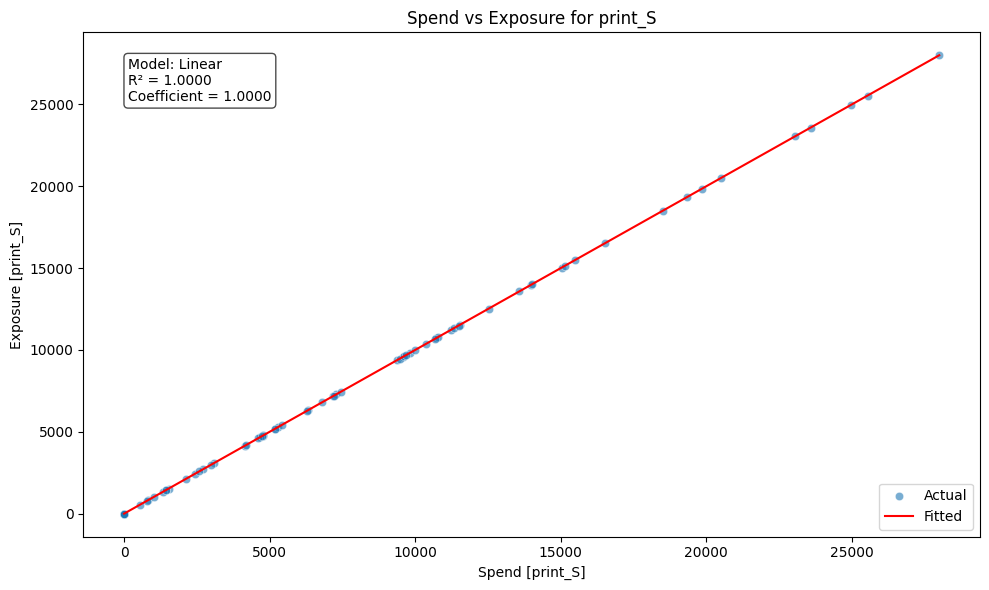

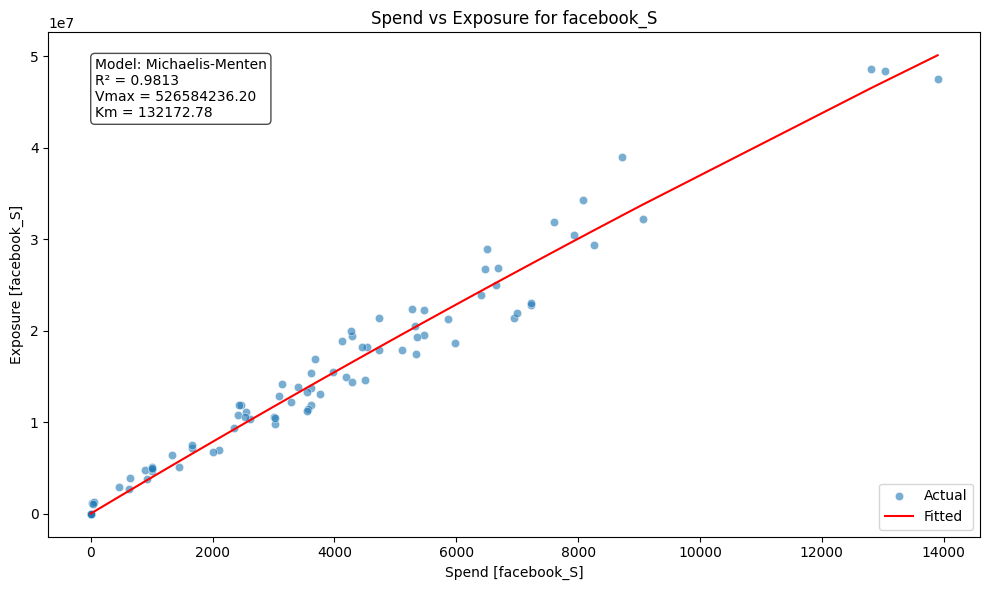

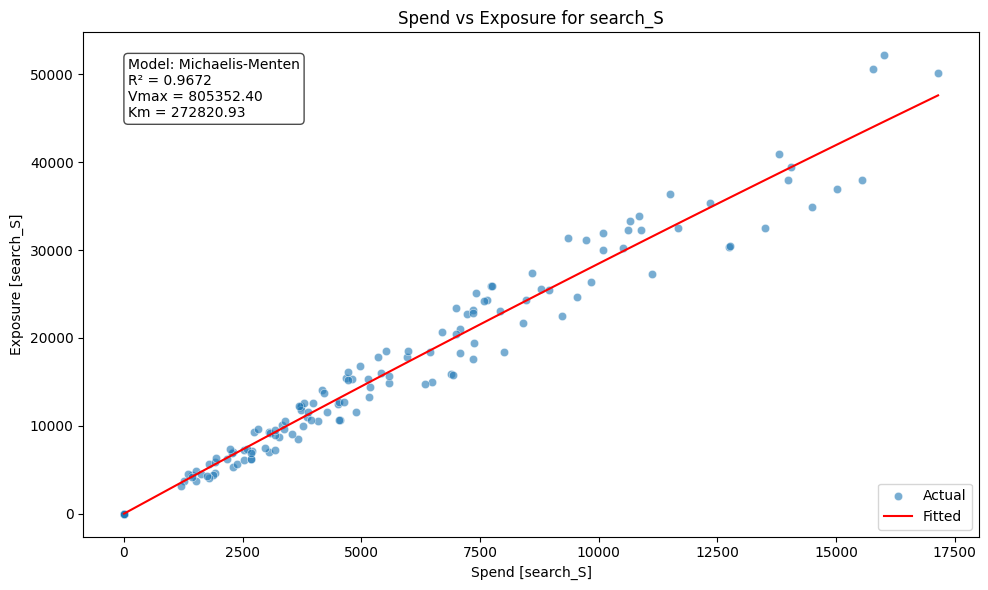

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)


# Plot spend-exposure relationship for each channel
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

In [9]:
print("After Prophet fitting Python data:")
print(featurized_mmm_data.dt_mod[["trend", "season", "holiday", "events"]].describe())

After Prophet fitting Python data:
              trend        season       holiday      events
count  2.080000e+02  2.080000e+02  2.080000e+02  208.000000
mean   2.464408e+06 -4.200662e+03  4.485713e+04    0.006711
std    2.734418e+04  6.749420e+05  1.770986e+05    0.074450
min    2.410718e+06 -1.051064e+06 -3.339534e+05    0.000000
25%    2.440887e+06 -6.708996e+05  0.000000e+00    0.000000
50%    2.466341e+06 -5.934451e+04  0.000000e+00    0.000000
75%    2.489693e+06  6.465492e+05  0.000000e+00    0.000000
max    2.503485e+06  1.217579e+06  1.039102e+06    1.000000


In [10]:
featurized_mmm_data.dt_mod["events"].unique()

array([0.        , 1.        , 0.39590026])

In [11]:
print("After Prophet fitting Python data:")
print(featurized_mmm_data.dt_mod[["trend", "season", "holiday"]].describe())

After Prophet fitting Python data:
              trend        season       holiday
count  2.080000e+02  2.080000e+02  2.080000e+02
mean   2.464408e+06 -4.200662e+03  4.485713e+04
std    2.734418e+04  6.749420e+05  1.770986e+05
min    2.410718e+06 -1.051064e+06 -3.339534e+05
25%    2.440887e+06 -6.708996e+05  0.000000e+00
50%    2.466341e+06 -5.934451e+04  0.000000e+00
75%    2.489693e+06  6.465492e+05  0.000000e+00
max    2.503485e+06  1.217579e+06  1.039102e+06
